## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration points using chessboard images

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = '../camera_cal/cornersfound/corners_found'+str(images.index(fname))+'.jpg'
        cv2.imwrite(write_name, img)

### Use the object points and image points to calibrate and undistort the camera

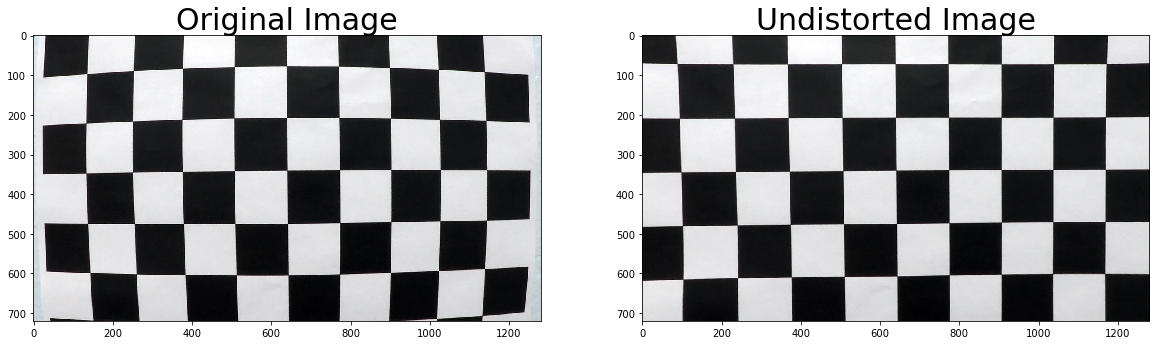

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use the image of a straight road to kickstart the process

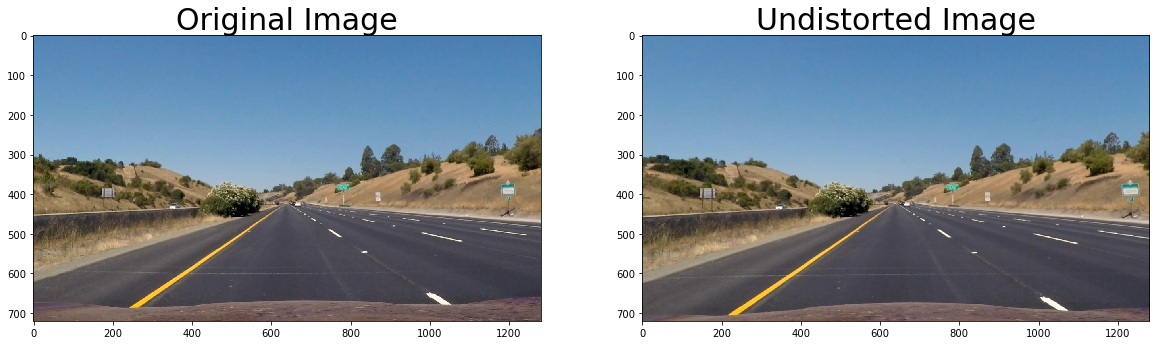

In [7]:
import pickle
%matplotlib inline
dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = cv2.imread('../test_images/straight_lines1.jpg')
img = img[...,::-1] # rotate back to rgb
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [10]:
import example as e

img = np.copy(img)
# Convert to HSV color space and separate the V channel
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
red = img[:,:,0]

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
mag_binary = e.mag_thresh(gray, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = e.dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
red_gradx = e.abs_sobel_thresh(red, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grey_gradx = e.abs_sobel_thresh(red, orient='x', sobel_kernel=ksize, thresh=(20, 100))

s_thresh=(170, 255)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

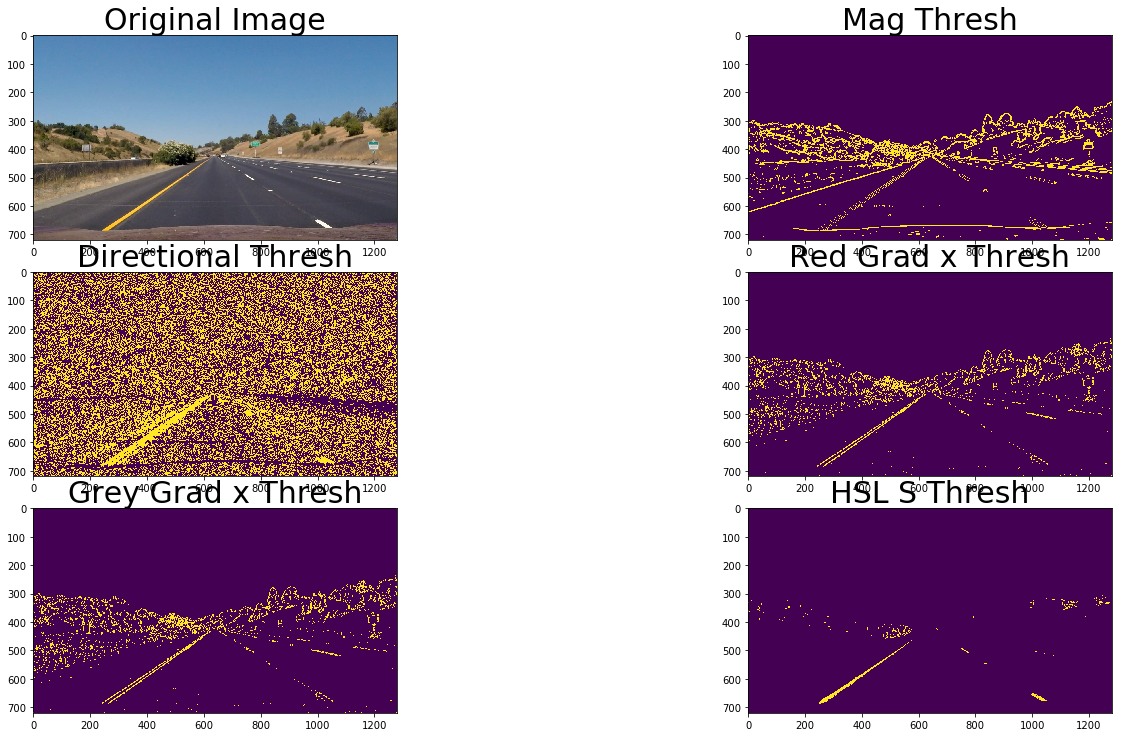

In [14]:
%matplotlib inline
f, axarr = plt.subplots(3, 2, figsize=(20,10))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=30)

axarr[0, 1].imshow(mag_binary)
axarr[0, 1].set_title('Mag Thresh', fontsize=30)

axarr[1, 0].imshow(dir_binary)
axarr[1, 0].set_title('Directional Thresh', fontsize=30)

axarr[1, 1].imshow(red_gradx)
axarr[1, 1].set_title('Red Grad x Thresh', fontsize=30)

axarr[2, 0].imshow(grey_gradx)
axarr[2, 0].set_title('Grey Grad x Thresh', fontsize=30)

axarr[2, 1].imshow(s_binary)
axarr[2, 1].set_title('HSL S Thresh', fontsize=30)

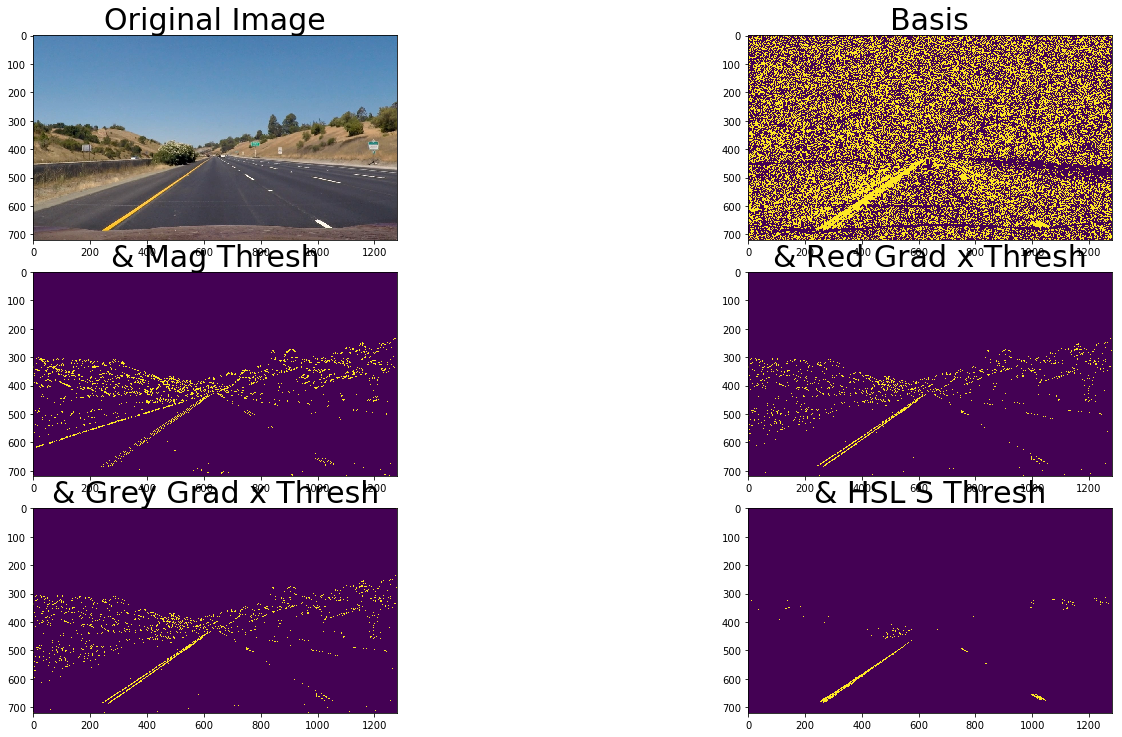

In [16]:
dir_mag = np.zeros_like(dir_binary)
dir_mag[(dir_binary == 1) & (mag_binary == 1)] = 1

redx_mag = np.zeros_like(dir_binary)
redx_mag[(dir_binary == 1) & (red_gradx == 1)] = 1

greyx_mag = np.zeros_like(dir_binary)
greyx_mag[(dir_binary == 1) & (grey_gradx == 1)] = 1

sbin_mag = np.zeros_like(dir_binary)
sbin_mag[(dir_binary == 1) & (s_binary == 1)] = 1


%matplotlib inline
f, axarr = plt.subplots(3, 2, figsize=(20,10))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=30)

axarr[0, 1].imshow(dir_binary)
axarr[0, 1].set_title('Basis', fontsize=30)

axarr[1, 0].imshow(dir_mag)
axarr[1, 0].set_title('& Mag Thresh', fontsize=30)

axarr[1, 1].imshow(redx_mag)
axarr[1, 1].set_title('& Red Grad x Thresh', fontsize=30)

axarr[2, 0].imshow(greyx_mag)
axarr[2, 0].set_title('& Grey Grad x Thresh', fontsize=30)

axarr[2, 1].imshow(sbin_mag)
axarr[2, 1].set_title('& HSL S Thresh', fontsize=30)

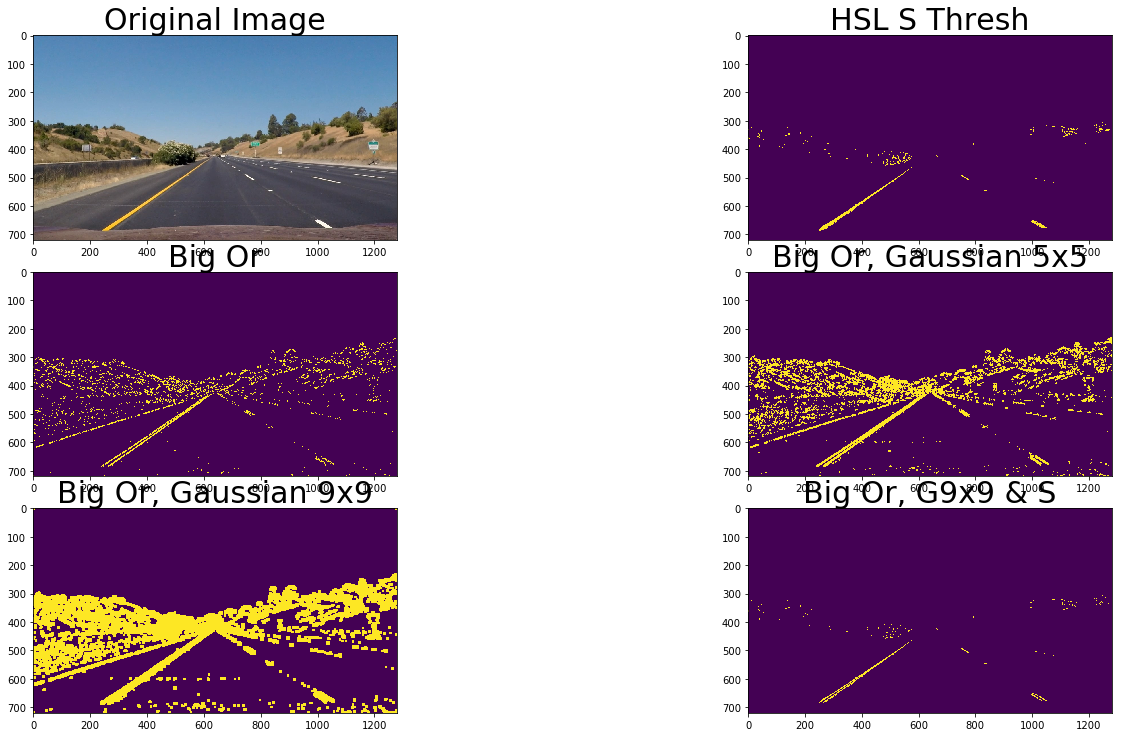

In [24]:
big_or = np.zeros_like(dir_binary)
big_or[(redx_mag == 1) | (greyx_mag == 1) | (dir_mag == 1)] = 1

big_or_g1_tmp = cv2.GaussianBlur(big_or,(3,3),0)
big_or_g1 = np.zeros_like(dir_binary)
big_or_g1[big_or_g1_tmp > 0] = 1

big_or_g2_tmp = cv2.GaussianBlur(big_or,(9,9),0)
big_or_g2 = np.zeros_like(dir_binary)
big_or_g2[big_or_g2_tmp > 0] = 1

big_or_and_s = np.zeros_like(dir_binary)
big_or_and_s[(big_or_g1 == 1) & (s_binary == 1)] = 1


%matplotlib inline
f, axarr = plt.subplots(3, 2, figsize=(20,10))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=30)

axarr[0, 1].imshow(s_binary)
axarr[0, 1].set_title('HSL S Thresh', fontsize=30)

axarr[1, 0].imshow(big_or)
axarr[1, 0].set_title('Big Or', fontsize=30)

axarr[1, 1].imshow(big_or_g1)
axarr[1, 1].set_title('Big Or, Gaussian 5x5', fontsize=30)

axarr[2, 0].imshow(big_or_g2)
axarr[2, 0].set_title('Big Or, Gaussian 9x9', fontsize=30)

axarr[2, 1].imshow(big_or_and_s)
axarr[2, 1].set_title('Big Or, G9x9 & S', fontsize=30)

In [ ]:
combined = np.zeros_like(mag_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


color_binary = np.dstack(( np.zeros_like(sx_dir_binary), sx_dir_binary, s_binary))